In [ ]:
import nltk
import string
# nltk.download('all')
import re
from nltk.corpus import stopwords
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Embedding
from keras.layers import Dense, Flatten, LSTM, Bidirectional
from keras.layers import Input, GlobalMaxPool1D, Dropout
from keras.layers import Activation
from keras.models import Model, Sequential
from keras import optimizers
from sklearn.model_selection import train_test_split

In [ ]:
BATCH_SIZE  = 2
EPOCHS = 3
df = pd.read_csv("classification.csv")
train, test = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
#divide our training data into features X and label Y
X_train = train['sentence'] #will be used to train our model on
X_test = test['sentence'] #will be used to predict the output labels to see how well our model has trained
y_train = train[['Deaths', 'Injury', 'Location', 'Date', 'Time']].values
y_test = test[['Deaths', 'Injury', 'Location', 'Date', 'Time']].values

In [ ]:
punct = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~“”'

Clean Text

In [ ]:
def clean_text(txt):
  txt = txt.strip() #remove additional white space before and after end of sentence
  # txt = txt.lower()
  txt = txt.replace("'s", "") # remove apostrophe s
  txt = txt.replace("\?a.m.", "am") # replace a.m.
  txt = txt.replace("\?p.m.", "pm") # replace p.m.
  text = "".join([c for c in txt if c not in punct]) #remove punct
  text = text.replace(u'\u2014', "")
  new_text = text.replace(r"\s+", " ") #remove additional space

  return new_text

In [ ]:
#cleans train and test text  
x_train, x_test = [], []
for sentence in X_train:
  x_train.append(clean_text(sentence))

for sentence in X_test:
  x_test.append(clean_text(sentence))

In [ ]:
train_max = max(len(ele) for ele in x_train) 
train_max

320

In [ ]:
test_max = max(len(ele) for ele in x_test) 
test_max

334

In [ ]:
from keras.preprocessing.text import Tokenizer
#calculate the vocabulary size as well which will be given as an input to the Embedding layer
tokens = Tokenizer() 
tokens.fit_on_texts(x_train)
vocab_size = len(tokens.word_index) + 1 #size of the total number of uniques tokens in our dataset
tokenized_train = tokens.texts_to_sequences(x_train) #converting our tokens into sequence of integers
tokenized_test = tokens.texts_to_sequences(x_test)

In [ ]:
print(x_train[0]) #the first text
print(100 * '-')
print(tokenized_train[0]) #the correspondin first comment in the vectorized form

The incident happened at Balogu North a suburb of Yendi around 1830GMT on Monday August 31
----------------------------------------------------------------------------------------------------
[1, 98, 61, 10, 2298, 101, 2, 1487, 4, 1488, 35, 2299, 8, 47, 202, 436]


**Pad Sequences**

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_len = 334 #max length of the padded sequence (one of the hyperparameter that can be tuned)
padded_train = pad_sequences(tokenized_train, maxlen = max_len, padding = 'post') #post padding our sequences with zeros
padded_test = pad_sequences(tokenized_test, maxlen = max_len)

In [ ]:
padded_train[:10]

array([[   1,   98,   61, ...,    0,    0,    0],
       [ 569,  235,    9, ...,    0,    0,    0],
       [   1,   81,  272, ...,    0,    0,    0],
       ...,
       [2305, 2306, 2307, ...,    0,    0,    0],
       [ 510,  472,  369, ...,    0,    0,    0],
       [ 569,  235,  223, ...,    0,    0,    0]], dtype=int32)

**GLOVE**

In [ ]:
import numpy as np

embedding_dim = 50
vocab_size = len(tokens.word_index) + 1  # Adding again 1 because of reserved 0 index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

with open('/content/drive/MyDrive/FYP/glove.6B.50d.txt', encoding = 'utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokens.word_index:
            idx = tokens.word_index[word] 
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False))
model1.add(LSTM(60, return_sequences = True))
model1.add(Activation('relu'))
model1.add(GlobalMaxPool1D())
model1.add(Dropout(0.1))
# model1.add(Dense(120, activation = 'relu'))
# model1.add(Dropout(0.001))
model1.add(Dense(50, activation = 'relu'))
model1.add(Dropout(0.1))
model1.add(Dense(5, activation = 'sigmoid'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 334, 50)           249300    
_________________________________________________________________
lstm (LSTM)                  (None, 334, 60)           26640     
_________________________________________________________________
activation (Activation)      (None, 334, 60)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

In [ ]:
optim = optimizers.Adam(lr = 0.001, decay = 0.01 / 64)
model1.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['acc'])
history1 = model1.fit(padded_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.1)

Epoch 1/3
852/852 [==============================] - 55s 63ms/step - loss: 0.5796 - acc: 0.3505 - val_loss: 0.3699 - val_acc: 0.5842
Epoch 2/3
852/852 [==============================] - 53s 62ms/step - loss: 0.3468 - acc: 0.5544 - val_loss: 0.2578 - val_acc: 0.6684
Epoch 3/3
852/852 [==============================] - 53s 62ms/step - loss: 0.2617 - acc: 0.5953 - val_loss: 0.2188 - val_acc: 0.6474


In [ ]:
max(history1.history['acc'])

0.6024662256240845

In [ ]:
max(history1.history['val_acc'])

0.6684210300445557

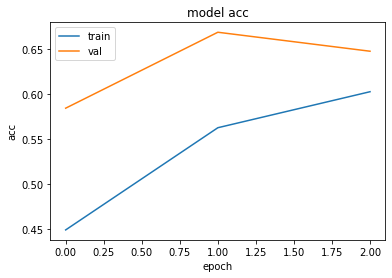

In [ ]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

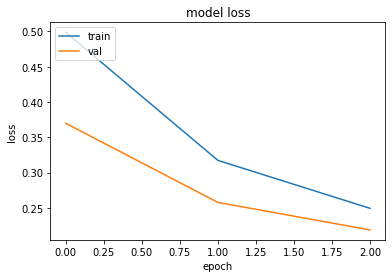

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(padded_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
106/106 [==============================] - 3s 23ms/step - loss: 0.2220 - acc: 0.6256
test loss, test acc: [0.2219824343919754, 0.6255924105644226]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions1 = model1.predict(padded_test)
print("predictions shape:", predictions1.shape)
print("predictions shape:\n", predictions1[1:5])

Generate predictions for 3 samples
predictions shape: (211, 5)
predictions shape:
 [[0.08111583 0.9048571  0.14716598 0.02511542 0.02606146]
 [0.03075166 0.97455376 0.21217941 0.00605354 0.00622698]
 [0.01131309 0.08276746 0.8451115  0.32128614 0.96142685]
 [0.00418187 0.02852652 0.98779863 0.53050625 0.98703164]]


In [ ]:
y_test[1:5]

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1]])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
print ("Batch Size: ", BATCH_SIZE)
print ("LSTM Classification report: \n", (classification_report(y_test, predictions1.round())))
print ("F1 micro averaging:",(f1_score(y_test, predictions1.round(), average='micro')))

Batch Size:  2
LSTM Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.85      0.91        80
           1       0.82      0.87      0.84        91
           2       0.88      0.94      0.91       112
           3       0.94      0.87      0.91        71
           4       0.93      0.93      0.93        61

   micro avg       0.90      0.89      0.90       415
   macro avg       0.91      0.89      0.90       415
weighted avg       0.90      0.89      0.90       415
 samples avg       0.89      0.89      0.88       415

F1 micro averaging: 0.8972188633615478


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


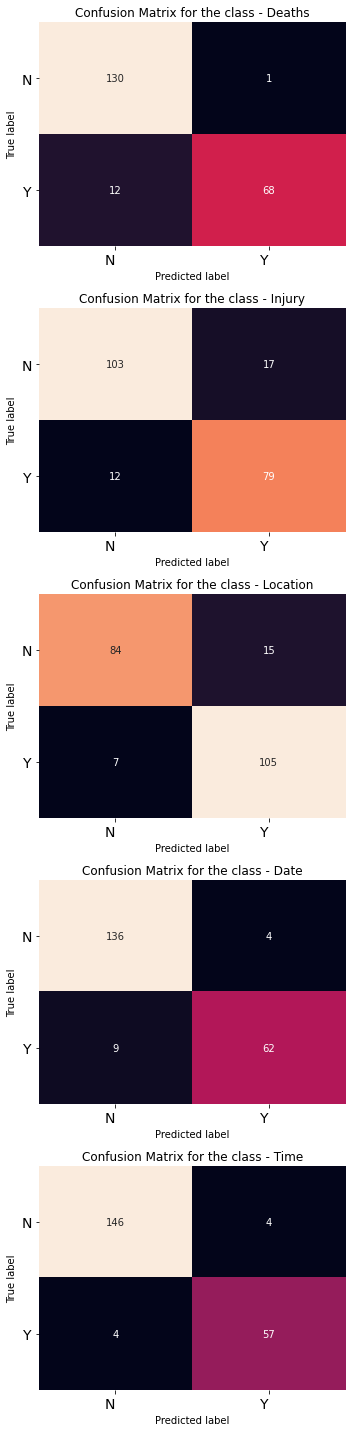

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr = np.asarray(multilabel_confusion_matrix(y_test, predictions1.round()))
labels = ['Deaths', 'Injury', 'Location', 'Date', 'Time']
# import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(5, 1, figsize=(5, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [ ]:
# model1.save_weights('multi_lstm_B02_03.h5')

**GLOVE- BILSTM**

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False))
model2.add(Bidirectional(LSTM(60, return_sequences = True)))
model2.add(Activation('relu'))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.1))
# model2.add(Dense(150, activation = 'relu'))
# model2.add(Dropout(0.1))
model2.add(Dense(120, activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(Dense(50, activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(Dense(5, activation = 'sigmoid'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 334, 50)           249300    
_________________________________________________________________
bidirectional (Bidirectional (None, 334, 120)          53280     
_________________________________________________________________
activation_1 (Activation)    (None, 334, 120)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)              

In [ ]:
optim = optimizers.Adam(lr = 0.001, decay = 0.01 / 64)
model2.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['acc'])
history2 = model2.fit(padded_train, y_train, epochs =EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.1)

Epoch 1/3
852/852 [==============================] - 108s 122ms/step - loss: 0.5603 - acc: 0.3855 - val_loss: 0.2995 - val_acc: 0.5684
Epoch 2/3
852/852 [==============================] - 103s 120ms/step - loss: 0.2868 - acc: 0.5848 - val_loss: 0.2479 - val_acc: 0.6263
Epoch 3/3
852/852 [==============================] - 103s 121ms/step - loss: 0.2163 - acc: 0.6280 - val_loss: 0.2244 - val_acc: 0.6526


In [ ]:
max(history2.history['acc'])

0.6065766215324402

In [ ]:
max(history2.history['val_acc'])

0.6526315808296204

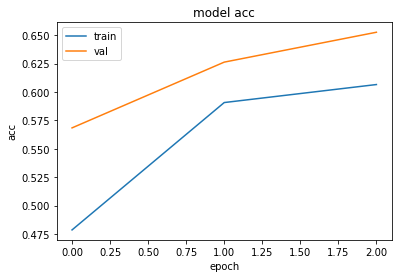

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

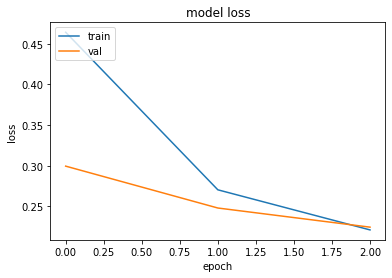

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model2.evaluate(padded_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
106/106 [==============================] - 6s 44ms/step - loss: 0.1823 - acc: 0.6445
test loss, test acc: [0.18227626383304596, 0.6445497870445251]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions2 = model2.predict(padded_test)
print("predictions shape:", predictions2.shape)
print("predictions shape:\n", predictions2[1:5])

Generate predictions for 3 samples
predictions shape: (211, 5)
predictions shape:
 [[0.05847296 0.9144637  0.05261112 0.0223624  0.01187523]
 [0.02250565 0.96724856 0.04741941 0.002111   0.00214842]
 [0.01338511 0.05317337 0.6813898  0.97386646 0.98895395]
 [0.00379547 0.00584594 0.9979798  0.26699764 0.993616  ]]


In [ ]:
y_test[1:5]

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1]])

In [ ]:
print ("Batch Size: ", BATCH_SIZE)
print ("BiLSTM Classification report: \n", (classification_report(y_test, predictions2.round())))
print ("F1 micro averaging:",(f1_score(y_test, predictions2.round(), average='micro')))

Batch Size:  2
BiLSTM Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.93      0.75      0.83        91
           2       0.89      0.90      0.89       112
           3       0.93      0.99      0.96        71
           4       0.94      1.00      0.97        61

   micro avg       0.92      0.91      0.91       415
   macro avg       0.93      0.92      0.92       415
weighted avg       0.92      0.91      0.91       415
 samples avg       0.91      0.90      0.89       415

F1 micro averaging: 0.913730255164034


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


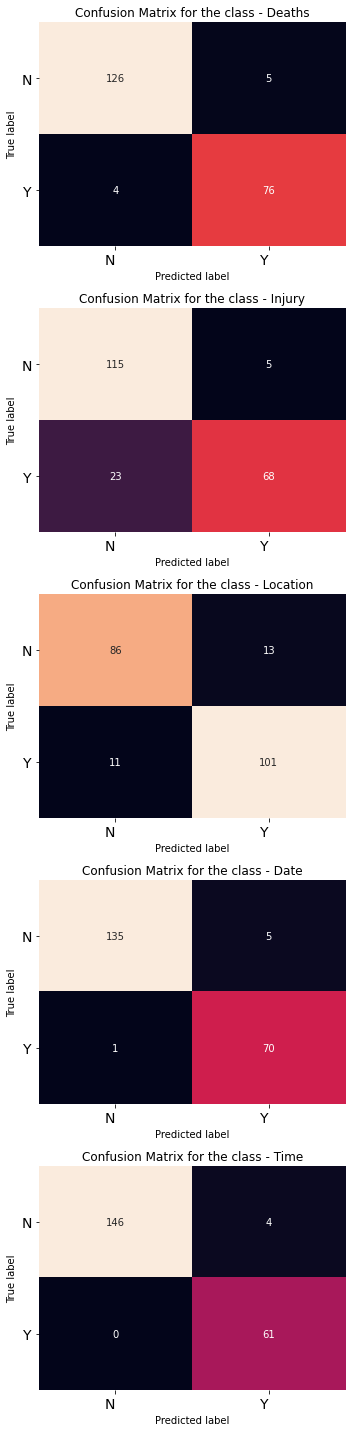

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr2 = np.asarray(multilabel_confusion_matrix(y_test, predictions2.round()))
labels = ['Deaths', 'Injury', 'Location', 'Date', 'Time']
# import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(5, 1, figsize=(5, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr2, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [ ]:
# model2.save_weights('multi_bilstm_B02_03.h5')